In [ ]:
# A) Kill the current Git repo entirely
%cd /content
!rm -rf DeepLense_Test               # remove the folder
!rm -rf ~/.gitconfig                 # optional: clears cached user/email


/content


In [ ]:
# In Colab – easiest via GitHub CLI, but web UI works too
!gh repo create Marques225/DeepLense_Test --public --confirm

/bin/bash: line 1: gh: command not found


In [ ]:
# clone empty repo
!git clone https://github.com/Marques225/DeepLense_Test.git
%cd DeepLense_Test

Cloning into 'DeepLense_Test'...
/content/DeepLense_Test


In [ ]:
!git config --global user.name  "Marques Wright"
!git config --global user.email "msw22500@gmail.com"

In [ ]:
!git add .
!git commit -m "Initial clean commit – no secrets"

On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)


In [ ]:
import os, getpass, subprocess
if "GH_TOKEN" not in os.environ:
    os.environ["GH_TOKEN"] = getpass.getpass("GitHub PAT (hidden): ")
subprocess.run("git remote set-url origin https://$GH_TOKEN@github.com/Marques225/DeepLense_Test.git", shell=True)
subprocess.run("git push -u origin main", shell=True)

GitHub PAT (hidden): ··········


CompletedProcess(args='git push -u origin main', returncode=1)

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/DeepLense Test.ipynb" .

In [ ]:
!printf "data/*\n!data/README.md\n" > .gitignore
!mkdir -p data
!echo "Put the .npy files here, or set DEEPLENSE_DATA_DIR." > data/README.md
!echo "# list your pip deps here" > requirements.txt

In [ ]:
!ls -1
# should list: DeepLense_Test.ipynb  .gitignore  requirements.txt  data/

data
'DeepLense Test.ipynb'
requirements.txt


In [ ]:
# still inside /content/DeepLense_Test
!printf "data/*\n!data/README.md\n" > .gitignore

In [ ]:
!git add .gitignore

In [ ]:
!git commit -m "Add .gitignore to keep data files out of Git"

[main (root-commit) ee38229] Add .gitignore to keep data files out of Git
 1 file changed, 2 insertions(+)
 create mode 100644 .gitignore


In [9]:
# optional rename for neatness
!mv "DeepLense Test.ipynb" DeepLense_Test.ipynb

# stage & commit
!git add DeepLense_Test.ipynb
!git commit -m "Add cleaned notebook"

mv: cannot stat 'DeepLense Test.ipynb': No such file or directory
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git push origin main

Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 8 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (6/6), 9.30 KiB | 9.30 MiB/s, done.
Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/Marques225/DeepLense_Test.git
 * [new branch]      main -> main


In [ ]:
%cd /content/DeepLense_Test

/content/DeepLense_Test


In [ ]:
# requirements.txt — put real deps later if you know them
!echo "# Add your pip packages here" > requirements.txt

# data/README.md placeholder
!mkdir -p data
!echo "Place the .npy files here, or set DEEPLENSE_DATA_DIR to point elsewhere." > data/README.md

In [ ]:
!git add requirements.txt data/README.md
!git commit -m "Add requirements.txt and data README placeholder"

[main 0c74671] Add requirements.txt and data README placeholder
 2 files changed, 2 insertions(+)
 create mode 100644 data/README.md
 create mode 100644 requirements.txt


In [ ]:
!git push origin main

Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (5/5), 552 bytes | 552.00 KiB/s, done.
Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/Marques225/DeepLense_Test.git
   60ee133..0c74671  main -> main


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Sample image shape: (1, 150, 150)


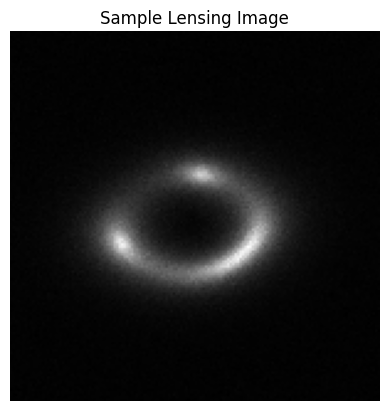

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to the folder containing the .npy files
data_dir = "/content/drive/MyDrive/Colab Notebooks/Samples"

# List all .npy files
npy_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])

# Load a sample image
sample_path = os.path.join(data_dir, npy_files[0])
sample_img = np.load(sample_path)

print("Sample image shape:", sample_img.shape)

# Visualize
sample_img = sample_img.squeeze()  # shape will become (150, 150)
plt.imshow(sample_img, cmap='gray')
plt.title('Sample Lensing Image')
plt.axis('off')
plt.show()


In [3]:
import torch
import numpy as np
import os

# Load all images into a single tensor (may take time and memory)
all_images = []
for file in npy_files:
    img = np.load(os.path.join(data_dir, file))  # shape might be (1, H, W) or (H, W)
    all_images.append(img)

all_images = np.array(all_images)
all_images = all_images.astype(np.float32) / 255.0  # Normalize

# Convert to torch tensor
all_images = torch.tensor(all_images)

# If your images have shape (N, 1, H, W) and you want (N, 1, H, W), no problem
# But if shape is (N, 1, 1, H, W), remove the extra 1 dim at index 2
if all_images.dim() == 5 and all_images.shape[2] == 1:
    all_images = all_images.squeeze(2)  # Remove that extra dimension

# If images are (N, H, W), add channel dim at 1
elif all_images.dim() == 3:
    all_images = all_images.unsqueeze(1)

print("Dataset shape:", all_images.shape)

Dataset shape: torch.Size([10020, 1, 150, 150])


SOLUTION ATTEMPT 2

In [7]:
'''SOLUTION ATTEMPT 2'''
import torch, math, numpy as np, pandas as pd
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as PSNR, structural_similarity as SSIM

# ────────────────────────────── Device ──────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────── LensingDataset helper ──────────────────────────────
class LensingDataset(Dataset):
    def __init__(self, tensor):  # (N,1,H,W)
        self.data = tensor
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx]
        return x  # assume already (1,H,W)

# ───────────────────────── Time-embedding utils ─────────────────────────────
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim): super().__init__(); self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        emb = torch.exp(torch.arange(half, device=t.device) * -(math.log(10000) / (half-1)))
        emb = t[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

# ───────────────────────── Residual & U-Net ─────────────────────────────────
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time  = nn.Linear(t_dim, out_ch)
        self.act   = nn.SiLU()
        self.res   = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
    def forward(self, x, t_emb):
        h = self.act(self.conv1(x))
        h = h + self.time(t_emb)[:, :, None, None]
        h = self.act(self.conv2(h))
        return h + self.res(x)

class BetterUNet(nn.Module):
    def __init__(self, img_ch=1, base=64, t_dim=256):
        super().__init__()
        self.t_emb = nn.Sequential(
            SinusoidalPosEmb(t_dim), nn.Linear(t_dim, t_dim*4), nn.SiLU(), nn.Linear(t_dim*4, t_dim)
        )
        self.down1 = ResidualBlock(img_ch, base, t_dim)
        self.down2 = ResidualBlock(base, base*2, t_dim)
        self.down3 = ResidualBlock(base*2, base*4, t_dim)
        self.pool  = nn.MaxPool2d(2)
        self.mid   = ResidualBlock(base*4, base*4, t_dim)
        self.up3   = ResidualBlock(base*8, base*2, t_dim)
        self.up2   = ResidualBlock(base*4, base,   t_dim)
        self.up1   = ResidualBlock(base*2, base,   t_dim)
        self.up    = nn.Upsample(scale_factor=2, mode='nearest')
        self.out   = nn.Conv2d(base, img_ch, 3, padding=1)
    def forward(self, x, t):
        t_emb = self.t_emb(t)
        h1 = self.down1(x, t_emb)
        h2 = self.down2(self.pool(h1), t_emb)
        h3 = self.down3(self.pool(h2), t_emb)
        h_mid = self.mid(self.pool(h3), t_emb)
        h = self.up(h_mid)
        h = F.interpolate(h, size=h3.shape[-2:], mode='nearest')
        h = self.up3(torch.cat([h, h3], dim=1), t_emb)
        h = self.up(h)
        h = F.interpolate(h, size=h2.shape[-2:], mode='nearest')
        h = self.up2(torch.cat([h, h2], dim=1), t_emb)
        h = self.up(h)
        h = F.interpolate(h, size=h1.shape[-2:], mode='nearest')
        h = self.up1(torch.cat([h, h1], dim=1), t_emb)
        return self.out(h)

# ───────────────────────── Diffusion helpers ────────────────────────────────
def linear_beta_schedule(T): return torch.linspace(1e-4, 2e-2, T, device=device)
def get_idx(vals, t, shape): return vals.gather(0, t).view(t.size(0), *([1]*(len(shape)-1)))
def fwd_diff(x0, t, sqrt_ac, sqrt_1mac):
    noise = torch.randn_like(x0)
    return get_idx(sqrt_ac, t, x0.shape)*x0 + get_idx(sqrt_1mac, t, x0.shape)*noise, noise

# ─── Multi-step DDIM Inversion (deterministic, η=0) ───────────────────────────
@torch.no_grad()
def ddim_inverse_steps(x_t, t_start, model, alpha_bar, num_steps):
    """
    Deterministic DDIM inversion with `num_steps` from t_start -> 0.
    """
    # build the sequence of timesteps (include t_start and 0)
    seq = np.linspace(t_start, 0, num_steps + 1, dtype=int)
    seq = np.unique(seq)[::-1]  # descending, without duplicates
    x = x_t
    for idx in range(len(seq) - 1):
        t = int(seq[idx])
        next_t = int(seq[idx + 1])
        # predict noise
        tt = torch.full((x.size(0),), t, dtype=torch.long, device=x.device)
        eps = model(x, tt)
        # compute x0 estimate
        sqrt_ab_t = alpha_bar[t].sqrt()
        sqrt_1m_ab_t = (1 - alpha_bar[t]).sqrt()
        x0_est = (x - sqrt_1m_ab_t * eps) / sqrt_ab_t
        # project to next timestep
        sqrt_ab_next = alpha_bar[next_t].sqrt()
        sqrt_1m_ab_next = (1 - alpha_bar[next_t]).sqrt()
        x = sqrt_ab_next * x0_est + sqrt_1m_ab_next * eps
    return x.clamp(0, 1)

# ─── Compute One-step Metrics ─────────────────────────────────────────────────
@torch.no_grad()
def compute_one_step_metrics(model, x0, t, schedules):
    _, _, alpha_bar, sqrt_ab, sqrt_1m_ab = schedules
    noise = torch.randn_like(x0)
    x_t = sqrt_ab[t] * x0 + sqrt_1m_ab[t] * noise
    eps_pred = model(x_t, torch.full((x0.size(0),), t, dtype=torch.long, device=device))
    mse = F.mse_loss(eps_pred, noise).item()
    corr = ((eps_pred.flatten() * noise.flatten()).mean() /
            (eps_pred.std() * noise.std())).item()
    x0_hat = (x_t - sqrt_1m_ab[t] * eps_pred) / sqrt_ab[t]
    x0_np, x0_hat_np = x0.cpu().numpy(), x0_hat.cpu().numpy()
    psnrs = [PSNR(a.squeeze(), b.squeeze(), data_range=1.0) for a, b in zip(x0_np, x0_hat_np)]
    ssims = [SSIM(a.squeeze(), b.squeeze(), data_range=1.0) for a, b in zip(x0_np, x0_hat_np)]
    return {'noise_mse': mse, 'noise_corr': corr,
            'psnr_1step': np.mean(psnrs), 'ssim_1step': np.mean(ssims)}

# ─── Training with Integrated Metrics ─────────────────────────────────────────
def train(model, train_loader, val_loader, opt, T,
          epochs=100, ema_decay=0.999, val_interval=5):
    # prepare schedules and EMA
    beta = linear_beta_schedule(T)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, 0)
    sqrt_ab, sqrt_1m_ab = alpha_bar.sqrt(), (1 - alpha_bar).sqrt()
    schedules = (beta, alpha, alpha_bar, sqrt_ab, sqrt_1m_ab)
    ema = BetterUNet().to(device)
    ema.load_state_dict(model.state_dict())
    for p in ema.parameters(): p.requires_grad_(False)

    metrics = []
    best_loss = float('inf')
    no_improve = 0
    for ep in range(1, epochs + 1):
        # TRAIN STEP
        model.train()
        ep_loss = 0.0
        for x in tqdm(train_loader, desc=f"Epoch {ep}"):
            x = x.to(device)
            t = torch.randint(0, T, (x.size(0),), device=device).long()
            x_t, noise = fwd_diff(x, t, sqrt_ab, sqrt_1m_ab)
            pred = model(x_t, t)
            loss = F.mse_loss(pred, noise)
            opt.zero_grad(); loss.backward(); opt.step()
            ep_loss += loss.item()
            # EMA update
            with torch.no_grad():
                for pe, p in zip(ema.parameters(), model.parameters()):
                    pe.data.mul_(ema_decay).add_(p.data, alpha=1-ema_decay)
        ep_loss /= len(train_loader)
        # checkpoint EMA
        if ep_loss < best_loss:
            best_loss = ep_loss; no_improve = 0
            torch.save(ema.state_dict(), 'best_ema.pt')
        else:
            no_improve += 1
        if no_improve > 10: break

        # VALIDATION METRICS
        if ep % val_interval == 0:
            for split, loader in [('train', train_loader), ('val', val_loader)]:
                x0 = next(iter(loader)).to(device)
                for t in [50, 200, 400, 800]:
                    # one-step
                    one = compute_one_step_metrics(ema, x0, t, schedules)
                    one.update({'epoch': ep, 'split': split, 't': t, 'steps': 1})
                    metrics.append(one)
                    # multi-step
                    for steps in [5, 10, 25, 50]:
                        x_t = sqrt_ab[t] * x0 + sqrt_1m_ab[t] * torch.randn_like(x0)
                        x_rec = ddim_inverse_steps(x_t, t, ema, alpha_bar, steps)
                        x_np, rec_np = x0.cpu().numpy(), x_rec.cpu().numpy()
                        psnrs = [PSNR(a.squeeze(), b.squeeze(), data_range=1.0)
                                 for a, b in zip(x_np, rec_np)]
                        ssims = [SSIM(a.squeeze(), b.squeeze(), data_range=1.0)
                                 for a, b in zip(x_np, rec_np)]
                        row = {'epoch': ep, 'split': split, 't': t,
                               'steps': steps,
                               'psnr_steps': np.mean(psnrs),
                               'ssim_steps': np.mean(ssims)}
                        metrics.append(row)

    # finish up
    df = pd.DataFrame(metrics)
    df.to_csv('metrics_log_two.csv', index=False)
    return ema, df

# ─── Main Entrypoint ─────────────────────────────────────────────────────────
if __name__ == '__main__':

    train_ds, val_ds = torch.utils.data.random_split(
        all_images, [int(0.9*len(all_images)), len(all_images) - int(0.9*len(all_images))]
    )
    train_loader = DataLoader(LensingDataset(train_ds), batch_size=64, shuffle=True)
    val_loader   = DataLoader(LensingDataset(val_ds),   batch_size=64, shuffle=False)

    model = BetterUNet().to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=3e-4)
    ema_model, metrics_df = train(model, train_loader, val_loader, opt,
                                  T=1000, epochs=100, val_interval=5)

    print(metrics_df.head())

Epoch 63: 100%|██████████| 141/141 [00:16<00:00,  8.62it/s]

   noise_mse  noise_corr  psnr_1step  ssim_1step  epoch  split   t  steps  \
0   0.603278    0.994816   17.284266    0.018805      5  train  50      1   
1        NaN         NaN         NaN         NaN      5  train  50      5   
2        NaN         NaN         NaN         NaN      5  train  50     10   
3        NaN         NaN         NaN         NaN      5  train  50     25   
4        NaN         NaN         NaN         NaN      5  train  50     50   

   psnr_steps  ssim_steps  
0         NaN         NaN  
1   20.599071    0.008223  
2   20.605260    0.008218  
3   20.565575    0.008102  
4   20.574236    0.008139  


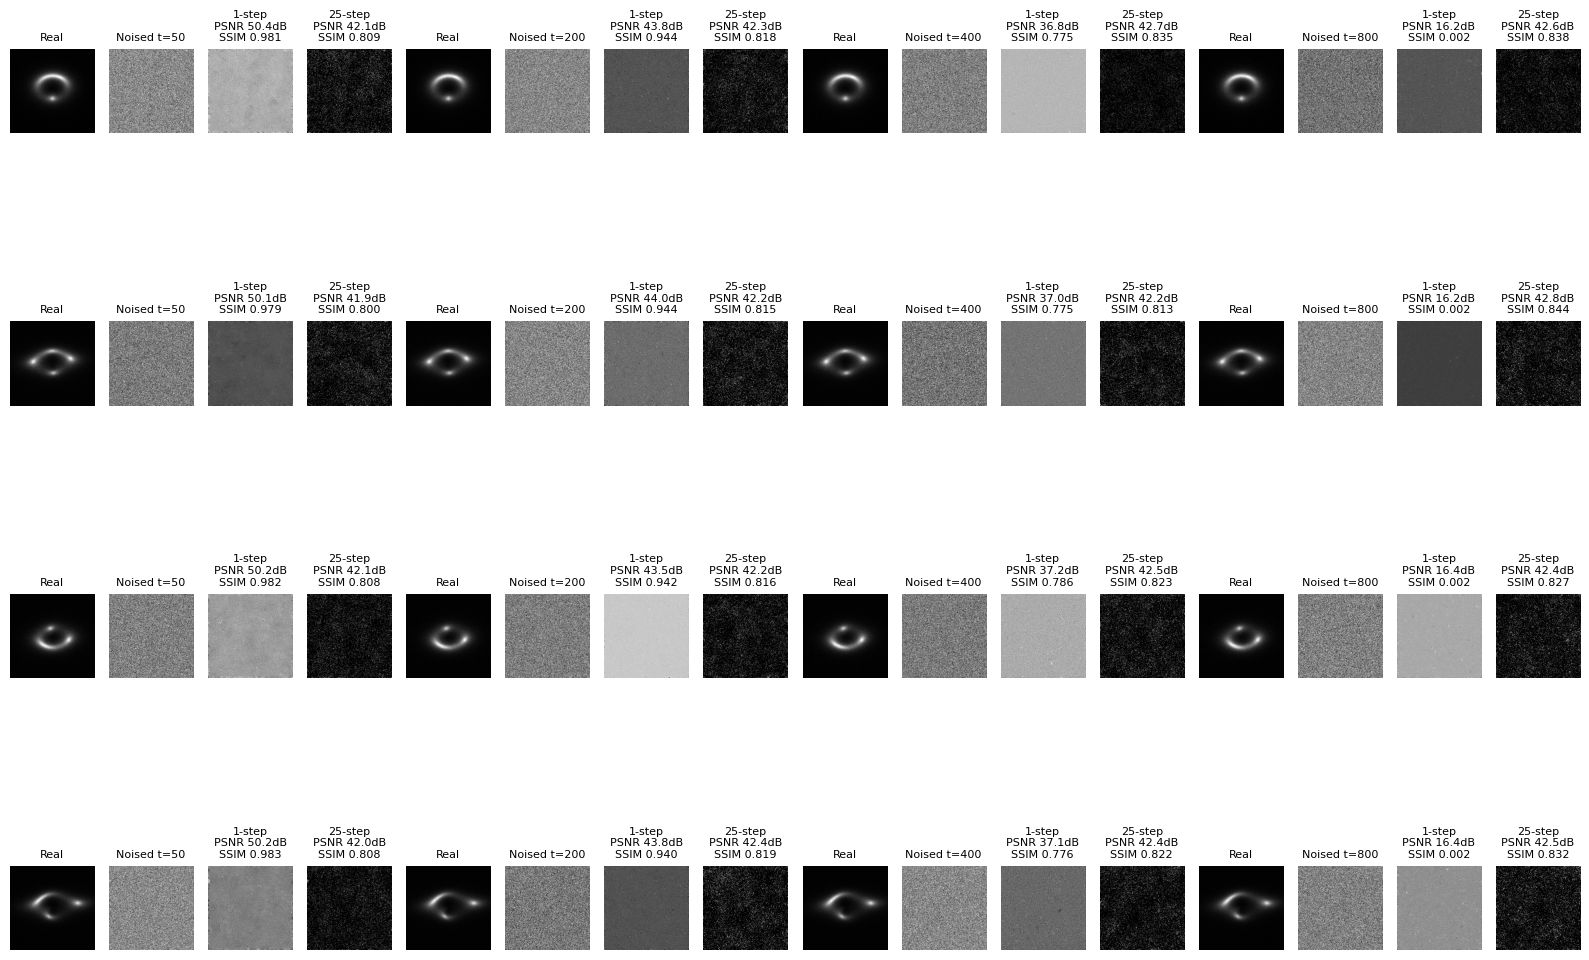

In [8]:
'''SOLUTION ATTEMPT 2'''
checkpoint = 'best_ema.pt'
num_steps  = 25
timesteps  = [50, 200, 400, 800]
n_samples  = 4

def linear_beta_schedule(T):
    return torch.linspace(1e-4, 2e-2, T, device=device)

def ddim_inverse_steps(x_t, t_start, model, alpha_bar, steps):
    seq = np.linspace(t_start, 0, steps+1, dtype=int)
    seq = np.unique(seq)[::-1]
    x = x_t
    for i in range(len(seq)-1):
        t, nt = int(seq[i]), int(seq[i+1])
        tt = torch.full((x.size(0),), t, dtype=torch.long, device=device)
        eps = model(x, tt)
        sqrt_ab  = alpha_bar[t].sqrt()
        sqrt_1ma = (1-alpha_bar[t]).sqrt()
        x0_est   = (x - sqrt_1ma*eps)/sqrt_ab
        sqrt_ab2  = alpha_bar[nt].sqrt()
        sqrt_1ma2 = (1-alpha_bar[nt]).sqrt()
        x = sqrt_ab2*x0_est + sqrt_1ma2*eps
    return x.clamp(0,1)

model = BetterUNet().to(device)
ckpt  = torch.load(checkpoint, map_location=device)
model.load_state_dict(ckpt)
model.eval()

T = 1000
beta = linear_beta_schedule(T)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, 0)

val_ds = all_images[int(0.9*len(all_images)):]
model.eval()
with torch.no_grad():
    samples = val_ds[:n_samples].to(device)

    fig, axes = plt.subplots(n_samples, len(timesteps)*4,
                             figsize=(4*len(timesteps), 3*n_samples))

    for i, x0 in enumerate(samples):
        x0 = x0.unsqueeze(0)

        for j, t in enumerate(timesteps):
            # forward noise
            noise    = torch.randn_like(x0)
            sqrt_ab  = alpha_bar[t].sqrt()
            sqrt_1ma = (1 - alpha_bar[t]).sqrt()
            x_t      = sqrt_ab * x0 + sqrt_1ma * noise

            # 1-step
            tt = torch.full((1,), t, dtype=torch.long, device=device)
            eps = model(x_t, tt)
            x1  = (x_t - sqrt_1ma * eps) / sqrt_ab

            # 25-step
            x25 = ddim_inverse_steps(x_t, t, model, alpha_bar, num_steps)

            # compute metrics (detach so no grad)
            a0 = x0.detach().cpu().numpy().squeeze()
            a1 = x1.detach().cpu().numpy().squeeze()
            a25 = x25.detach().cpu().numpy().squeeze()

            p1 = PSNR(a0,  a1,  data_range=1.0)
            s1 = SSIM(a0,  a1,  data_range=1.0)
            p2 = PSNR(a0, a25, data_range=1.0)
            s2 = SSIM(a0, a25, data_range=1.0)

            imgs   = [x0, x_t, x1, x25]
            titles = [
                "Real",
                f"Noised t={t}",
                f"1-step\nPSNR {p1:.1f}dB\nSSIM {s1:.3f}",
                f"25-step\nPSNR {p2:.1f}dB\nSSIM {s2:.3f}"
            ]

            for k, (im, title) in enumerate(zip(imgs, titles)):
                arr = im.detach().cpu().squeeze()        # ② detach here too
                ax  = axes[i, j*4 + k]
                ax.imshow(arr, cmap='gray')
                ax.set_title(title, fontsize=8)
                ax.axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
!pip install diffusers accelerate

SOLUTION ATTEMPT 1

In [4]:
'''SOLUTION ATTEMPT 1'''

import torch, math, numpy as np
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class LensingDataset(Dataset):
    def __init__(self, tensor):                       # (N, 1, 150, 150)
        self.data = tensor
    def __len__(self):  return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx]
        if x.dim() == 4 and x.shape[1] == 1:          # squeeze stray dim
            x = x.squeeze(1)
        return x

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__(); self.dim=dim
    def forward(self, t):                             # t: (B,)
        half = self.dim // 2
        emb  = torch.exp(torch.arange(half, device=t.device) *
                         -(math.log(10000) / (half-1)))
        emb  = t[:,None] * emb[None,:]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)   # (B,dim)

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
        self.time  = nn.Linear(t_dim, out_ch)
        self.act   = nn.SiLU()
        self.res   = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
    def forward(self, x, t_emb):
        h = self.act(self.conv1(x))
        h = h + self.time(t_emb)[:, :, None, None]
        h = self.act(self.conv2(h))
        return h + self.res(x)

class BetterUNet(nn.Module):
    def __init__(self, img_ch=1, base=64, t_dim=256):
        super().__init__()
        # time embedding MLP
        self.t_emb = nn.Sequential(
            SinusoidalPosEmb(t_dim), nn.Linear(t_dim, t_dim*4), nn.SiLU(),
            nn.Linear(t_dim*4, t_dim)
        )
        # encoder
        self.down1 = ResidualBlock(img_ch,       base,   t_dim)
        self.down2 = ResidualBlock(base,         base*2, t_dim)
        self.down3 = ResidualBlock(base*2,       base*4, t_dim)
        self.pool  = nn.MaxPool2d(2)
        # bottleneck
        self.mid   = ResidualBlock(base*4,       base*4, t_dim)
        # decoder
        self.up3   = ResidualBlock(base*8,       base*2, t_dim)
        self.up2   = ResidualBlock(base*4,       base,   t_dim)
        self.up1   = ResidualBlock(base*2,       base,   t_dim)
        self.up    = nn.Upsample(scale_factor=2, mode='nearest')
        self.out   = nn.Conv2d(base, img_ch, 3, 1, 1)

    def forward(self, x, t):
      t_emb = self.t_emb(t)

      # encoder
      h1 = self.down1(x,                 t_emb)
      h2 = self.down2(self.pool(h1),     t_emb)
      h3 = self.down3(self.pool(h2),     t_emb)
      h_mid = self.mid(self.pool(h3),    t_emb)

      # decoder  (resize to exactly match the skip tensor)
      h = self.up(h_mid)
      h = F.interpolate(h, size=h3.shape[-2:], mode="nearest")
      h = self.up3(torch.cat([h, h3], 1), t_emb)

      h = self.up(h)
      h = F.interpolate(h, size=h2.shape[-2:], mode="nearest")
      h = self.up2(torch.cat([h, h2], 1), t_emb)

      h = self.up(h)
      h = F.interpolate(h, size=h1.shape[-2:], mode="nearest")
      h = self.up1(torch.cat([h, h1], 1), t_emb)

      return self.out(h)

def linear_beta_schedule(T):  return torch.linspace(1e-4, 2e-2, T, device=device)

def get_idx(vals, t, shp):
    out = vals.gather(-1, t).view(t.size(0), *((1,)*(len(shp)-1)))
    return out
def fwd_diff(x0, t, sqrt_ac, sqrt_1mac):
    noise = torch.randn_like(x0)
    return get_idx(sqrt_ac,t,x0.shape)*x0 + get_idx(sqrt_1mac,t,x0.shape)*noise, noise

def train(model, loader, opt, T, epochs=100, ema_decay=0.999,
          patience=10, min_delta=1e-5):
    beta  = linear_beta_schedule(T)
    alpha = 1. - beta
    ac    = torch.cumprod(alpha, 0)
    sqrt_ac, sqrt_1mac = ac.sqrt(), (1 - ac).sqrt()

    mse   = nn.MSELoss()

    ema = BetterUNet().to(device)
    ema.load_state_dict(model.state_dict())
    for p in ema.parameters(): p.requires_grad_(False)

    best_loss = float('inf')
    epochs_no_improve = 0         # early-stop counter

    for ep in range(1, epochs + 1):
        pbar = tqdm(enumerate(loader), total=len(loader),
                    desc=f"Epoch {ep}")
        epoch_loss = 0.0

        for batch_idx, x in pbar:
            x = x.to(device)
            t = torch.randint(0, T, (x.size(0),), device=device).long()
            x_t, noise = fwd_diff(x, t, sqrt_ac, sqrt_1mac)

            # one-time debug on very first batch
            if ep == 1 and batch_idx == 0:
                with torch.no_grad():
                    mae_dbg = (model(x_t, t) - noise).abs().mean()
                    print("MAE(noise,pred) first batch:", mae_dbg.item())

            pred  = model(x_t, t)
            loss  = mse(pred, noise)
            epoch_loss += loss.item()

            opt.zero_grad(); loss.backward(); opt.step()

            # EMA update
            with torch.no_grad():
                for pe, p in zip(ema.parameters(), model.parameters()):
                    pe.data.mul_(ema_decay).add_(p.data, alpha=1-ema_decay)

            pbar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss /= len(loader)          # mean loss this epoch

        if epoch_loss < best_loss - min_delta:
            best_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(ema.state_dict(), "best_ema.pt")
            print(f"✓ saved best EMA (loss {best_loss:.4e})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early-stopping: no improvement for {patience} epochs.")
                break
# Loading Tensor
print('Original dataset shape:', all_images.shape)

train_sz = int(0.9*len(all_images))
val_sz   = len(all_images)-train_sz
train_ds,_ = torch.utils.data.random_split(all_images, [train_sz, val_sz])
train_loader = DataLoader(LensingDataset(train_ds), batch_size=64, shuffle=True)

model = BetterUNet().to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=3e-4)
train(model, train_loader, opt, T=1000, epochs=100)


Using device: cuda
Original dataset shape: torch.Size([10020, 1, 150, 150])


Epoch 1:   0%|          | 0/141 [00:00<?, ?it/s]

MAE(noise,pred) first batch: 0.8628383874893188


Epoch 1: 100%|██████████| 141/141 [00:17<00:00,  7.88it/s, loss=0.0086]


✓ saved best EMA (loss 1.1721e-01)


Epoch 2: 100%|██████████| 141/141 [00:16<00:00,  8.66it/s, loss=0.0022]


✓ saved best EMA (loss 1.9291e-02)


Epoch 3: 100%|██████████| 141/141 [00:16<00:00,  8.67it/s, loss=0.0016]


✓ saved best EMA (loss 1.1316e-02)


Epoch 4: 100%|██████████| 141/141 [00:16<00:00,  8.66it/s, loss=0.0029]


✓ saved best EMA (loss 1.0128e-02)


Epoch 5: 100%|██████████| 141/141 [00:16<00:00,  8.67it/s, loss=0.0034]


✓ saved best EMA (loss 5.9898e-03)


Epoch 6: 100%|██████████| 141/141 [00:16<00:00,  8.67it/s, loss=0.0019]


✓ saved best EMA (loss 3.9027e-03)


Epoch 7: 100%|██████████| 141/141 [00:16<00:00,  8.66it/s, loss=0.0047]


✓ saved best EMA (loss 3.6462e-03)


Epoch 8: 100%|██████████| 141/141 [00:16<00:00,  8.65it/s, loss=0.0031]


✓ saved best EMA (loss 3.3412e-03)


Epoch 9: 100%|██████████| 141/141 [00:16<00:00,  8.66it/s, loss=0.0007]


✓ saved best EMA (loss 2.1402e-03)


Epoch 10: 100%|██████████| 141/141 [00:16<00:00,  8.66it/s, loss=0.0094]


✓ saved best EMA (loss 1.9322e-03)


Epoch 12: 100%|██████████| 141/141 [00:16<00:00,  8.65it/s, loss=0.0011]


✓ saved best EMA (loss 1.6686e-03)


Epoch 13: 100%|██████████| 141/141 [00:16<00:00,  8.66it/s, loss=0.0005]


✓ saved best EMA (loss 1.2992e-03)


Epoch 14: 100%|██████████| 141/141 [00:16<00:00,  8.65it/s, loss=0.0007]


✓ saved best EMA (loss 8.6042e-04)


Epoch 19: 100%|██████████| 141/141 [00:16<00:00,  8.65it/s, loss=0.0002]


✓ saved best EMA (loss 5.6343e-04)


Epoch 20: 100%|██████████| 141/141 [00:16<00:00,  8.66it/s, loss=0.0019]


✓ saved best EMA (loss 4.2695e-04)


Epoch 29: 100%|██████████| 141/141 [00:16<00:00,  8.65it/s, loss=0.0004]


✓ saved best EMA (loss 3.2656e-04)


Epoch 34: 100%|██████████| 141/141 [00:16<00:00,  8.65it/s, loss=0.0002]


✓ saved best EMA (loss 2.8156e-04)


Epoch 35: 100%|██████████| 141/141 [00:16<00:00,  8.65it/s, loss=0.0001]


✓ saved best EMA (loss 1.8601e-04)


Epoch 45: 100%|██████████| 141/141 [00:16<00:00,  8.65it/s, loss=0.0002]

Early-stopping: no improvement for 10 epochs.


In [5]:
'''SOLUTION ATTEMPT 1'''

# grab the first convolution weight tensor
w_loaded = model.down1.conv1.weight.view(-1)[:5].cpu()
print("first 5 weights from checkpoint:", w_loaded)

# rebuild a *fresh* model (random weights) and print the same tensor
fresh = BetterUNet().to(device)
w_rand  = fresh.down1.conv1.weight.view(-1)[:5].cpu()
print("first 5 random weights        :", w_rand)


first 5 weights from checkpoint: tensor([-0.3230, -0.3548, -0.0680,  0.0052,  0.1412],
       grad_fn=<ToCopyBackward0>)
first 5 random weights        : tensor([ 0.0828,  0.2090, -0.0530, -0.0148,  0.3224],
       grad_fn=<ToCopyBackward0>)


t=50: x_t range [-0.816, 0.663]
  noise-MSE=6.2837e-04, corr=1.000
t=200: x_t range [-2.363, 2.263]
  noise-MSE=2.0332e-04, corr=1.000
t=400: x_t range [-3.546, 3.958]
  noise-MSE=1.8378e-04, corr=1.000
t=800: x_t range [-3.947, 3.813]
  noise-MSE=4.1344e-04, corr=1.000


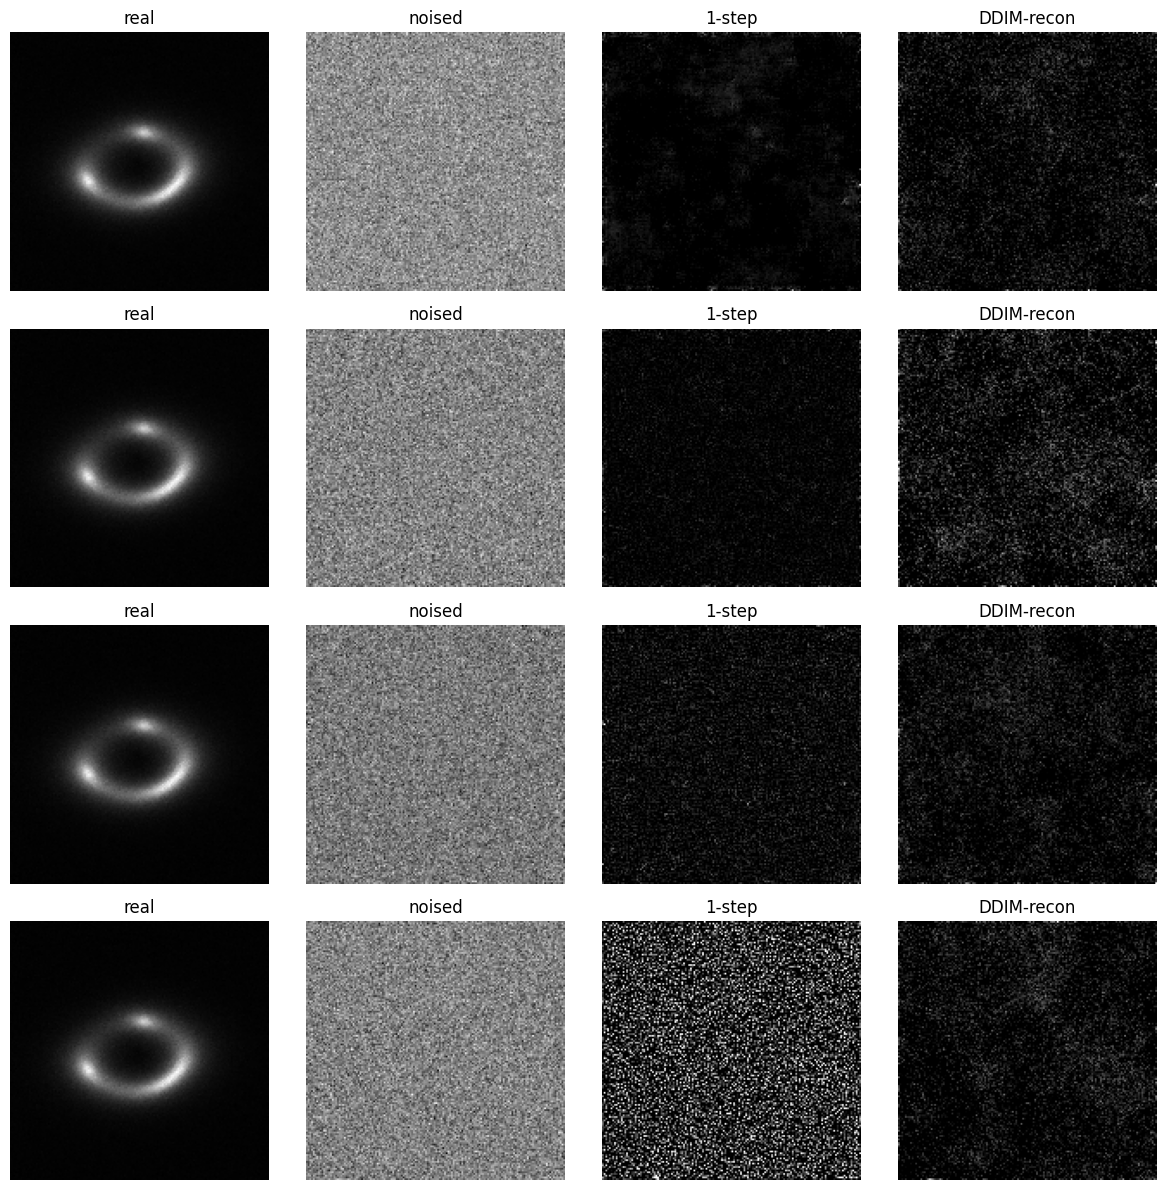

In [6]:
'''SOLUTION ATTEMPT 1'''

import torch
import matplotlib.pyplot as plt

# ─── 1) Load model ───────────────────────────────────────────────────────────────
def load_model(path, device):
    model = BetterUNet().to(device)
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()  # use running stats, disable dropout
    return model

# ─── 2) Build β/α schedules (must match your training) ───────────────────────────
def make_schedules(T, device):
    beta      = torch.linspace(1e-4, 2e-2, T, device=device)
    alpha     = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    sqrt_ab   = alpha_bar.sqrt()
    sqrt_1m_ab= (1.0 - alpha_bar).sqrt()
    return beta, alpha, alpha_bar, sqrt_ab, sqrt_1m_ab

# ─── 3) One‐step closed‐form inversion (quick sanity check) ─────────────────────
@torch.no_grad()
def one_step_inversion(x_t, t, model, sqrt_ab, sqrt_1m_ab):
    eps_pred = model(x_t, torch.full((x_t.size(0),), t,
                                     dtype=torch.long, device=x_t.device))
    x0_hat   = (x_t - sqrt_1m_ab[t] * eps_pred) / sqrt_ab[t]
    return x0_hat.clamp(0.0,1.0), eps_pred

# ─── 4) Deterministic DDIM inversion (η=0) ───────────────────────────────────────
@torch.no_grad()
def reconstruct_ddim(x_t, t_start, model, alpha_bar):
    x = x_t
    for t in range(t_start, 0, -1):  # t_start → 1
        tt          = torch.full((x.size(0),), t,
                                  dtype=torch.long, device=x.device)
        eps         = model(x, tt)
        sqrt_ab_t   = alpha_bar[t].sqrt()
        sqrt_1m_ab_t= (1.0 - alpha_bar[t]).sqrt()
        # one-shot x0 estimate
        x0_est      = (x - sqrt_1m_ab_t * eps) / sqrt_ab_t
        # project to x_{t-1}
        sqrt_ab_t1   = alpha_bar[t-1].sqrt()
        sqrt_1m_ab_t1= (1.0 - alpha_bar[t-1]).sqrt()
        x = sqrt_ab_t1 * x0_est + sqrt_1m_ab_t1 * eps
    return x.clamp(0.0,1.0)

# ─── 5) Diagnostics & Visualization ─────────────────────────────────────────────
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model, T = load_model('best_ema.pt', device), 1000
    beta, alpha, alpha_bar, sqrt_ab, sqrt_1m_ab = make_schedules(T, device)

    # timesteps to test (skip t=0 for inversion)
    timesteps = [50, 200, 400, 800]
    x0 = all_images[0:1].to(device)  # shape (1,1,H,W), float32 ∈ [0,1]

    fig, axes = plt.subplots(len(timesteps), 4, figsize=(12, 3*len(timesteps)))
    for i, t in enumerate(timesteps):
        # forward noise
        noise = torch.randn_like(x0)
        x_t   = sqrt_ab[t] * x0 + sqrt_1m_ab[t] * noise

        print(f"t={t}: x_t range [{x_t.min():.3f}, {x_t.max():.3f}]")

        # 1-step inversion & noise metrics
        x0_hat, eps_pred = one_step_inversion(x_t, t, model, sqrt_ab, sqrt_1m_ab)
        mse  = torch.mean((eps_pred - noise)**2).item()
        corr = ((eps_pred.flatten()*noise.flatten()).mean() /
                (eps_pred.std()*noise.std())).item()
        print(f"  noise-MSE={mse:.4e}, corr={corr:.3f}")

        # deterministic full inversion
        x_rec = reconstruct_ddim(x_t, t, model, alpha_bar)

        # plot real, noised, 1-step, DDIM-recon
        for j, (img, title) in enumerate(zip(
                [x0, x_t, x0_hat, x_rec],
                ['real','noised','1-step','DDIM-recon'])):
            ax = axes[i, j]
            ax.imshow(img[0,0].cpu(), cmap='gray')
            ax.set_title(title)
            ax.axis('off')

    plt.tight_layout()
    plt.show()
